# <center> Traducción en doble sentido entre Chino e Inglés usando Transformers
#### <center> $John \ Alexander \ Osorio \ Henao ^{1}$
   <center> $^{1}$ Instituto de Física, Universidad de Antioquia
           
#### <center> 21 de Abril del 2022
--------------------------------------------------------------
    

## <center> Resumen

En este trabajo se utiliza la tecnología de inteligencia artificial conocida como Transformer para modelar un traductor chino-inglés e inglés-chino. Durante la fase de entrenamiento, se calcula la entropía cruzada y se compara cuando se tiene conjunto de datos pequeño con uno relativamente mayor. Se ha descubierto que, para una cantidad no tan elevada de datos, las traducciones realizadas son coherentes con lo esperado sin requerir tanta capacidad de computo.

#### Palabras clave:
Transformer, MLT, Traducción, AI, ZH, EN

## <center> I. Introducción
Cada vez es más frecuente que comunidades con culturas e idiomas muy diferentes entren en contacto como resultado de los avances tecnológicos y los procesos de globalización [1]. Esto hace necesaria la implementación de tecnologías como los traductores para facilitar la comunicación entre estas.

Por otro lado, gracias a los avances en los algoritmos de inteligencia artificial, que han demostrado ser cada vez más capaces de realizar tareas con gran precisión y de forma autónoma, la traducción asistida por ordenador ha ganado popularidad en los últimos años [2]. La traducción forma parte del conjunto de tareas conocida como Seq2Seq (secuencia a secuencia), que también incluye el resumen de textos [3], la decodificación de cadenas de ADN [4] y la conversión de texto a voz [5], entre otros.

El método tradicional para realizar las tareas de Seq2Seq era utilizar redes neuronales recurrentes (RNN) y un mecanismo de memoria conocido como LSTM, que permitía acceder a cada segmento de la secuencia. Sin embargo, este método tenía problemas de paralelización, lo que aumentaba el coste computacional. Google presentó la tecnología Transformer en su artículo $\textit{Attention is all you need}$ (La atención es todo lo que necesitas) [6], que no sólo demostró ser más eficiente desde el punto de vista computacional, sino también más preciso que otros modelos. Ahora es el estándar de la industria para completar las tareas de Seq2Seq [7].

El objetivo de este trabajo es utilizar el Transformer de pytorch para modelar y entrenar un traductor chino-inglés y otro inglés-chino. Además, investigamos cómo cambia la entropía cruzada con el número de interacciones o épocas de entrenamiento.

##  <center> II. Marco Teórico

La principal característica del transformer es la implementación de un mecanismo de atención o attention mechanism, que permite al transformer recibir información de forma no secuencial. Un mecanismo de atención se compone de tres partes: la consulta, Q, la clave, K, y el valor, V. A cada palabra de una frase se le asigna uno de estos componentes [1]. El mecanismo de atención utilizará la representación de la consulta para la palabra actual y la comparará con cada clave en una secuencia de palabras. Calculará una puntuación, la cual será escalada con la siguiente ecuación [2]:

$$ \text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V $$

Donde la función softmax produce un valor entre 0 y 1, $\sqrt{d_k}$ es un factor de escala [2]. Esto indica la correlación entre las palabras, es decir, qué palabras de la frase son relevantes para la palabra actual y, por tanto, solo se enfocará en ellas.

En la fig. 1 se muestra la arquitectura de un Transformer. Este se basa en un modelo Codificador-Decodificador y multiples conexiones entre ellos. A continuación se describirán ambos componentes con más detalle.

 ![Fig1. Arquitectura de un transformer.](https://www.researchgate.net/publication/323904682/figure/fig1/AS:606458626465792@1521602412057/The-Transformer-model-architecture.png)

### Codificador 

El codificador recibe los datos y los transforma en una secuencia de datos continua (matriz numérica), que recibe el decodificador [1]. Esto se denomina incrustación. Un codificador se compone de seis capas idénticas con pesos diferentes, y cada capa se compone de dos subcapas: El mecanismo de autoatención multicapas, el cual es una implementación de mecanismos de atención múltiple que recibe diferentes consultas, claves y valores de la oración y produce un resultado en paralelo. Y una subcapa feed-forward totalmente conectada, cuyas capas internas implementan la función de activación ReLU y cuyo propósito es enriquecer el proceso de aprendizaje. Estas subcapas comparten una función de normalización de la salida, así como conexiones residuales [1, 2].

Hay que tener en cuenta que el proceso de parelización provoca la pérdida de información sobre la posición de cada palabra en la frase. Para solucionar esto, se añade una nueva representación conocida como codificación posicional que tiene el mismo tamaño que la representación continua. Esta se produce superponiendo funciones de seno y coseno de frecuencias variables [2, 3].

### Decodificador

La estructura del decodificador es similar a la del codificador, pero incluye una subcapa adicional conocida como enmascaramiento [1 - 3]. El codificador tiene acceso constante a todas las palabras de la frase, mientras que el decodificador sólo tiene acceso a las palabras anteriores. El objetivo es predecir la siguiente palabra utilizando las anteriores como guía. El enmascaramiento se utiliza para impedir que el descodificador acceda a las demás palabras, eliminando la información correspondiente a éstas [1].

##  <center> III. Códigos y Resultados

Para la realización del presente trabajo, se tomó como referencia el traductor alemán-chino realizado por Pytorch [11]. Se mantuvieron los mismos parámetros del Transfomer de Google. Sin embargo, se tomó un BATCH_SIZE = 32 y un NUM_EPOCHS = 16 para los casos estudiados.

In [ ]:
#Si se requiere instalar librerias

!pip install --upgrade torchtext
!pip install --upgrade spacy
!python -m spacy download en_core_web_sm
!python -m spacy download zh_core_web_md

In [ ]:
#cargar archivos drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#para importar modulos personalizados
import sys
sys.path.append('/content/drive/My Drive/AE_FinalProject')
!ls

Mounted at /content/drive
drive  sample_data  zh_en_mini.pt


In [ ]:
#librerías requeridas

from pickle import FALSE
#dataset y model corresponden a módulos creados para reducir la cantidad de código del notebook
from dataset import Dataset
from model import Seq2SeqTransformer, PositionalEncoding, TokenEmbedding

import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torch import Tensor
import io
import time

torch.manual_seed(0)
torch.use_deterministic_algorithms(False)

### Códigos para el entrenamiento del modelo

In [ ]:
#algoritmos para enmascarar el target y source.
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE))
            == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf'
                                    )).masked_fill(mask == 1,
            float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return (src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

#algoritmos de entrenamiento y validación
def train_epoch(model, train_iter, optimizer):
    model.train()
    losses = 0
    for (idx, (src, tgt)) in enumerate(train_iter):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        (src_mask, tgt_mask, src_padding_mask, tgt_padding_mask) = \
            create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
            )

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        #calculamos el valor de la cross-entropy
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]),
                       tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
    return losses / len(train_iter)


def evaluate(model, valid_iter):
    model.eval()
    losses = 0
    for (idx, (src, tgt)) in enumerate(valid_iter):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        (src_mask, tgt_mask, src_padding_mask, tgt_padding_mask) = \
            create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
            )
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]),
                       tgt_out.reshape(-1))
        losses += loss.item()
    return losses / len(val_iter)

### Proceso de traducción 

In [ ]:
#esta función se utiliza para decodificar los datos que arroja el modelo y poderlos procesar como texto 
def greedy_decode(
    model,
    src,
    src_mask,
    max_len,
    start_symbol,
    ):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1,
                    1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len - 1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0],
                                  memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = \
            generate_square_subsequent_mask(ys.size(0)).type(torch.bool).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        (_, next_word) = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1,
                       1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

#traducción mediante el uso de tokens - en el diccionario de target se buscan las posiciones que ha generado el traductor.
def translate(
    model,
    src,
    src_vocab,
    tgt_vocab,
    src_tokenizer,
    ):
    model.eval()

    tokens = [BOS_IDX]
    #por si hay palabras que no conoce
    for tok in src_tokenizer(src):
      try:
        stoi = src_vocab.get_stoi()[tok]
      except: 
        stoi = src_vocab['<unk>']
      tokens.append(stoi)
    tokens += [EOS_IDX]
    num_tokens = len(tokens)
    src = torch.LongTensor(tokens).reshape(num_tokens, 1)
    src_mask = torch.zeros(num_tokens, num_tokens).type(torch.bool)
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=num_tokens
                               + 5, start_symbol=BOS_IDX).flatten()
    return ' '.join([tgt_vocab.get_itos()[tok] for tok in
                    tgt_tokens]).replace('<bos>', '').replace('<eos>',
            '')

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 16

### Carga de conjunto de datos pequeño

Primero se entrenará el modelo utilizando un conjunto de datos que contiene 1000 líneas en paralelo con las oraciones en inglés y chino. 

In [ ]:
#divisor de palabras para chino y para ingles
zh_tokenizer = get_tokenizer('spacy', language='zh_core_web_md')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
rel_path = '/content/drive/My Drive/AE_FinalProject/datasets/'

#### ZH - EN 

Comenzaremos por tomar como origen el Chino y destino el inglés. 

Epoch: 1, Train loss: 5.463, Epoch time = 0.857s
Epoch: 2, Train loss: 4.511, Epoch time = 0.771s
Epoch: 3, Train loss: 4.191, Epoch time = 0.769s
Epoch: 4, Train loss: 3.944, Epoch time = 0.767s
Epoch: 5, Train loss: 3.684, Epoch time = 0.773s
Epoch: 6, Train loss: 3.472, Epoch time = 0.782s
Epoch: 7, Train loss: 3.256, Epoch time = 0.781s
Epoch: 8, Train loss: 3.074, Epoch time = 0.775s
Epoch: 9, Train loss: 2.885, Epoch time = 0.769s
Epoch: 10, Train loss: 2.709, Epoch time = 0.777s
Epoch: 11, Train loss: 2.547, Epoch time = 0.780s
Epoch: 12, Train loss: 2.400, Epoch time = 0.771s
Epoch: 13, Train loss: 2.252, Epoch time = 0.777s
Epoch: 14, Train loss: 2.096, Epoch time = 0.772s
Epoch: 15, Train loss: 1.973, Epoch time = 0.777s
Epoch: 16, Train loss: 1.840, Epoch time = 0.770s


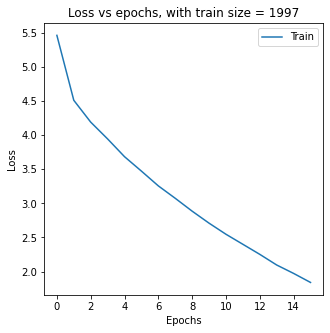

In [ ]:
src = 'zh' #origen
tgt = 'en' #destino
#especificamos las rutas de los datos

train_filepaths = [rel_path+'small/train.'+src, rel_path+'small/train.'+tgt]
val_filepaths = [rel_path+'small/val.'+src, rel_path+'small/val.'+tgt]
test_filepaths = [rel_path+'small/test.'+src, rel_path+'small/test.'+tgt]

ds = Dataset(zh_tokenizer, en_tokenizer)
ds.set_vocab(train_filepaths)
#se convierten los datos en un formato que pueda manipular el Transformer 
train_iter = ds.get_iter(train_filepaths, BATCH_SIZE)
test_iter = ds.get_iter(test_filepaths, BATCH_SIZE)
val_iter = ds.get_iter(val_filepaths, BATCH_SIZE)
device = torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))
PAD_IDX = ds.src_vocab['<pad>']
BOS_IDX = ds.src_vocab['<bos>']
EOS_IDX = ds.src_vocab['<eos>']

SRC_VOCAB_SIZE = len(ds.src_vocab)
TGT_VOCAB_SIZE = len(ds.tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 16

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

train_loss = []


for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss.append(train_epoch(transformer, train_iter, optimizer))
    end_time = time.time()
    print((f"Epoch: {epoch}, Train loss: {train_loss[-1]:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
    
torch.save(transformer.state_dict(), "zh_en_mini.pt")
    
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.title("Loss vs epochs, with train size = " + str(SRC_VOCAB_SIZE))
plt.plot(train_loss, label="Train")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc=0)



Observamos que el valor de la entropía cruzada decrece a medida que aumenta el número de epochs. Para el número de epochs usado, el valor final del loss está cercano a 2 para los datos, lo cual no es lo suficientemente pequeño. 

In [ ]:
transformer.load_state_dict(torch.load("zh_en_mini.pt"))

<All keys matched successfully>

Se escogeran ahora 10 oraciones al azar para verificar la traducción realizada por el modelo.

In [ ]:
import numpy as np
sent_src = rel_path + "small/val."
en = np.genfromtxt(sent_src+"en", delimiter='\n', dtype='str', encoding='utf8')
zh = np.genfromtxt(sent_src+"zh", delimiter='\n', dtype='str', encoding='utf8')

#10 random sentences
import random
idx = random.sample(range(0, len(en)), 10)

for i in idx:
  print("zh: ", zh[i])
  en_trans = translate(transformer, zh[i], ds.src_vocab, ds.tgt_vocab, zh_tokenizer)
  print("en - Transformer: ", en_trans.replace("\n", ""),"")
  print("en - Real:", en[i])
  print("\n")

zh:  不要取笑人。
en - Transformer:   Do n't throw the dog .   
en - Real: Don't make fun of people.


zh:  我和她聊得很愉快。
en - Transformer:   I 'm her and the same age .   
en - Real: I had a nice chat with her.


zh:  会有训练。
en - Transformer:   The clock has been in a car .   
en - Real: Training will be provided.


zh:  我把錢放入保險櫃裡。
en - Transformer:   I 'm tired of the same age .   
en - Real: I put the money into the safe.


zh:  我从没低估汤姆。
en - Transformer:   I am Tom .   
en - Real: I've never underestimated Tom.


zh:  问问他会不会说日语。
en - Transformer:   He is the book to the same He .   
en - Real: Ask him if he can speak Japanese.


zh:  她用一个微笑迎接了我。
en - Transformer:   She has a baby to the same .   
en - Real: She greeted me with a smile.


zh:  以前從來沒有人聽說過。
en - Transformer:   The clock has been to the girl .   
en - Real: Nobody had ever heard of it.


zh:  我没见到他。
en - Transformer:   I have n't understand his him .   
en - Real: I didn't see him.


zh:  我父母通常用法语对话，即使我母亲的母语是英语。
en - Transformer:

Ninguna de las oraciones traducidas es consistente con la traducción esperada. Solo en algunos casos, coinciden algunas palabras. Se entrenará ahora el traductror de inglés a Chino

#### EN - ZH

Epoch: 1, Train loss: 5.541, Epoch time = 0.878s
Epoch: 2, Train loss: 4.543, Epoch time = 0.787s
Epoch: 3, Train loss: 4.292, Epoch time = 0.801s
Epoch: 4, Train loss: 4.071, Epoch time = 0.796s
Epoch: 5, Train loss: 3.866, Epoch time = 0.783s
Epoch: 6, Train loss: 3.674, Epoch time = 0.804s
Epoch: 7, Train loss: 3.466, Epoch time = 0.777s
Epoch: 8, Train loss: 3.283, Epoch time = 0.793s
Epoch: 9, Train loss: 3.103, Epoch time = 0.785s
Epoch: 10, Train loss: 2.930, Epoch time = 0.789s
Epoch: 11, Train loss: 2.786, Epoch time = 0.792s
Epoch: 12, Train loss: 2.644, Epoch time = 0.813s
Epoch: 13, Train loss: 2.493, Epoch time = 0.788s
Epoch: 14, Train loss: 2.354, Epoch time = 0.777s
Epoch: 15, Train loss: 2.219, Epoch time = 0.787s
Epoch: 16, Train loss: 2.102, Epoch time = 0.877s


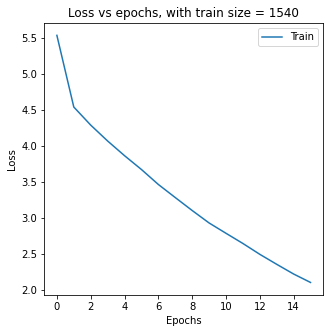

In [ ]:
src = 'en' #origen
tgt = 'zh' #destino
#especificamos las rutas de los datos

train_filepaths = [rel_path+'small/train.'+src, rel_path+'small/train.'+tgt]
val_filepaths = [rel_path+'small/val.'+src, rel_path+'small/val.'+tgt]
test_filepaths = [rel_path+'small/test.'+src, rel_path+'small/test.'+tgt]

ds = Dataset(en_tokenizer, zh_tokenizer)
ds.set_vocab(train_filepaths)
#se convierten los datos en un formato que pueda manipular el Transformer 
train_iter = ds.get_iter(train_filepaths, BATCH_SIZE)
test_iter = ds.get_iter(test_filepaths, BATCH_SIZE)
val_iter = ds.get_iter(val_filepaths, BATCH_SIZE)
device = torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))
PAD_IDX = ds.src_vocab['<pad>']
BOS_IDX = ds.src_vocab['<bos>']
EOS_IDX = ds.src_vocab['<eos>']

SRC_VOCAB_SIZE = len(ds.src_vocab)
TGT_VOCAB_SIZE = len(ds.tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 16

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

train_loss = []


for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss.append(train_epoch(transformer, train_iter, optimizer))
    end_time = time.time()
    print((f"Epoch: {epoch}, Train loss: {train_loss[-1]:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
    
torch.save(transformer.state_dict(), "en_zh_mini.pt")
    
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.title("Loss vs epochs, with train size = " + str(SRC_VOCAB_SIZE))
plt.plot(train_loss, label="Train")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc=0)



In [ ]:
transformer.load_state_dict(torch.load("en_zh_mini.pt"))

In [ ]:

import numpy as np
sent_src = rel_path + "small/val."
en = np.genfromtxt(sent_src+"en", delimiter='\n', dtype='str', encoding='utf8')
zh = np.genfromtxt(sent_src+"zh", delimiter='\n', dtype='str', encoding='utf8')

#10 random sentences
import random
idx = random.sample(range(0, len(en)), 10)

for i in idx:
  print("en: ", en[i])
  zh_trans = translate(transformer, str(en[i]), ds.src_vocab, ds.tgt_vocab, en_tokenizer)
  print("zh - Transformer: ", zh_trans.replace("\n", ""),"")
  print("zh - Real:", zh[i])
  print("\n")

en:  Let's go by bus.
zh - Transformer:   我们 现在 在 這裡 了 。   
zh - Real: 讓我們坐公共汽車去。


en:  That is your book.
zh - Transformer:   那 您 的 。   
zh - Real: 那是你的書。


en:  Karuizawa is famous as a summer resort.
zh - Transformer:   一 個 個 個 個 個 兄弟姐妹 。   
zh - Real: 輕井澤是著名的避暑勝地。


en:  Don't walk alone after dark.
zh - Transformer:   不要 往 河裡 這裡 。   
zh - Real: 不要一個人在黑暗中走。


en:  I don't like her face.
zh - Transformer:   我 不 她 的 信 。   
zh - Real: 我不喜歡她的臉。


en:  He doesn't speak our language.
zh - Transformer:   他 不 喜欢 一 個 噪音 。   
zh - Real: 他不會說我們的語言。


en:  It was not long before we met again by chance.
zh - Transformer:   他 在 我们 能 ， 我 們 的 时候 就 能  
zh - Real: 没多久，我们又碰巧遇到了。


en:  I didn't see him.
zh - Transformer:   我 不 想 他 。   
zh - Real: 我没见到他。


en:  Why did you show me this?
zh - Transformer:   你 为什么 我 在 你 ？   
zh - Real: 你为什么让我看这个？


en:  Please serve him his meal first.
zh - Transformer:   他 的 把 他 的 。   
zh - Real: 請先為他上菜。




La situación es similar a la anterior descrita. Se observan algunos carácteres similares, pero la oración completa es diferente.

### Conjunto de datos mayor

Se usará ahora un conjunto de datos que contiene 14533 líneas.

In [ ]:
src = 'zh' #origen
tgt = 'en' #destino
#especificamos las rutas de los datos

train_filepaths = [rel_path+'big/train.'+src, rel_path+'big/train.'+tgt]
val_filepaths = [rel_path+'big/val.'+src, rel_path+'big/val.'+tgt]
test_filepaths = [rel_path+'big/test.'+src, rel_path+'big/test.'+tgt]

ds = Dataset(zh_tokenizer, en_tokenizer)
ds.set_vocab(train_filepaths)
#se convierten los datos en un formato que pueda manipular el Transformer 
train_iter = ds.get_iter(train_filepaths, BATCH_SIZE)
test_iter = ds.get_iter(test_filepaths, BATCH_SIZE)
val_iter = ds.get_iter(val_filepaths, BATCH_SIZE)
device = torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))
PAD_IDX = ds.src_vocab['<pad>']
BOS_IDX = ds.src_vocab['<bos>']
EOS_IDX = ds.src_vocab['<eos>']

SRC_VOCAB_SIZE = len(ds.src_vocab)
TGT_VOCAB_SIZE = len(ds.tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 16

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)


Epoch: 1, Train loss: 4.411, Epoch time = 33.331s
Epoch: 2, Train loss: 3.365, Epoch time = 33.153s
Epoch: 3, Train loss: 2.961, Epoch time = 32.424s
Epoch: 4, Train loss: 2.648, Epoch time = 33.114s
Epoch: 5, Train loss: 2.383, Epoch time = 33.035s
Epoch: 6, Train loss: 2.154, Epoch time = 32.373s
Epoch: 7, Train loss: 1.943, Epoch time = 33.066s
Epoch: 8, Train loss: 1.753, Epoch time = 33.050s
Epoch: 9, Train loss: 1.588, Epoch time = 32.429s
Epoch: 10, Train loss: 1.439, Epoch time = 33.065s
Epoch: 11, Train loss: 1.305, Epoch time = 33.018s
Epoch: 12, Train loss: 1.182, Epoch time = 32.172s
Epoch: 13, Train loss: 1.069, Epoch time = 33.037s
Epoch: 14, Train loss: 0.967, Epoch time = 33.031s
Epoch: 15, Train loss: 0.877, Epoch time = 32.531s
Epoch: 16, Train loss: 0.793, Epoch time = 32.748s
Epoch: 17, Train loss: 0.718, Epoch time = 33.108s
Epoch: 18, Train loss: 0.650, Epoch time = 32.797s
Epoch: 19, Train loss: 0.589, Epoch time = 32.543s
Epoch: 20, Train loss: 0.534, Epoch time

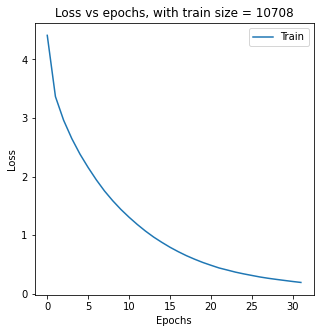

In [ ]:

train_loss = []


for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss.append(train_epoch(transformer, train_iter, optimizer))
    end_time = time.time()
    print((f"Epoch: {epoch}, Train loss: {train_loss[-1]:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
    
torch.save(transformer.state_dict(), "zh_en.pt")
    

plt.figure(figsize=(5, 5))
plt.title("Loss vs epochs, with train size = " + str(SRC_VOCAB_SIZE))
plt.plot(train_loss, label="Train")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc=0)



In [ ]:
transformer.load_state_dict(torch.load("zh_en.pt"))

<All keys matched successfully>

In [ ]:
import numpy as np
sent_src = rel_path + "big/val."
en = np.genfromtxt(sent_src+"en", delimiter='\n', dtype='str', encoding='utf8')
zh = np.genfromtxt(sent_src+"zh", delimiter='\n', dtype='str', encoding='utf8')

#10 random sentences
import random
idx = random.sample(range(0, len(en)), 10)

for i in idx:
  print("zh: ", zh[i])
  en_trans = translate(transformer, str(zh[i]), ds.src_vocab, ds.tgt_vocab, zh_tokenizer)
  print("en - Transformer: ", en_trans.replace("\n", ""),"")
  print("en - Real:", en[i])
  print("\n")

zh:  他把他的一生獻給了他的國家。
en - Transformer:   He put his life in his life .   
en - Real: He gave his life for his country.


zh:  你早餐想要吃什麼？
en - Transformer:   What do you want to eat for breakfast ?   
en - Real: What do you want for breakfast?


zh:  我會帶你去游泳。
en - Transformer:   I 'll show you to swim .   
en - Real: I will take you for a swim.


zh:  你真丢脸！
en - Transformer:   Shame on you .   
en - Real: Shame on you!


zh:  这不是我的初衷。
en - Transformer:   This is n't the made of mine .   
en - Real: That wasn't my intention.


zh:  我喜歡運動。
en - Transformer:   I love sports .   
en - Real: I like sports.


zh:  觉得渴了就喝点。
en - Transformer:   I think it will drink .   
en - Real: Feel free to get yourself a drink if you are thirsty.


zh:  您能教我弹钢琴吗？
en - Transformer:   Can you teach me to play the piano ?   
en - Real: Could you teach me how to play the piano?


zh:  早知道我不應該打電話給他。
en - Transformer:   I wonder why I should n't call him .   
en - Real: I should have known better than to call him.

La curva de entropía cruzada es suave. Se obtiene un valor mínimo mucho más pequeño y también las oraciones tienen más coherencia. Analicemos ahor el caso Inglés-Chino.

Epoch: 1, Train loss: 4.832, Epoch time = 35.202s
Epoch: 2, Train loss: 3.885, Epoch time = 35.881s
Epoch: 3, Train loss: 3.492, Epoch time = 35.975s
Epoch: 4, Train loss: 3.182, Epoch time = 34.970s
Epoch: 5, Train loss: 2.926, Epoch time = 35.867s
Epoch: 6, Train loss: 2.707, Epoch time = 35.910s
Epoch: 7, Train loss: 2.504, Epoch time = 35.035s
Epoch: 8, Train loss: 2.324, Epoch time = 35.895s
Epoch: 9, Train loss: 2.161, Epoch time = 35.746s
Epoch: 10, Train loss: 2.004, Epoch time = 35.017s
Epoch: 11, Train loss: 1.868, Epoch time = 35.762s
Epoch: 12, Train loss: 1.736, Epoch time = 35.780s
Epoch: 13, Train loss: 1.617, Epoch time = 35.022s
Epoch: 14, Train loss: 1.502, Epoch time = 35.851s
Epoch: 15, Train loss: 1.402, Epoch time = 35.835s
Epoch: 16, Train loss: 1.302, Epoch time = 35.091s


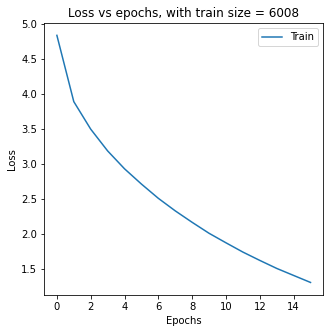

In [ ]:
src = 'en' #origen
tgt = 'zh' #destino
#especificamos las rutas de los datos

train_filepaths = [rel_path+'big/train.'+src, rel_path+'big/train.'+tgt]
val_filepaths = [rel_path+'big/val.'+src, rel_path+'big/val.'+tgt]
test_filepaths = [rel_path+'big/test.'+src, rel_path+'big/test.'+tgt]

ds = Dataset(en_tokenizer, zh_tokenizer)
ds.set_vocab(train_filepaths)
#se convierten los datos en un formato que pueda manipular el Transformer 
train_iter = ds.get_iter(train_filepaths, BATCH_SIZE)
test_iter = ds.get_iter(test_filepaths, BATCH_SIZE)
val_iter = ds.get_iter(val_filepaths, BATCH_SIZE)
device = torch.device(('cuda' if torch.cuda.is_available() else 'cpu'))
PAD_IDX = ds.src_vocab['<pad>']
BOS_IDX = ds.src_vocab['<bos>']
EOS_IDX = ds.src_vocab['<eos>']

SRC_VOCAB_SIZE = len(ds.src_vocab)
TGT_VOCAB_SIZE = len(ds.tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 16

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)


In [ ]:
transformer.load_state_dict(torch.load("en_zh.pt"))

In [ ]:
import numpy as np
sent_src = rel_path + "big/val."
en = np.genfromtxt(sent_src+"en", delimiter='\n', dtype='str', encoding='utf8')
zh = np.genfromtxt(sent_src+"zh", delimiter='\n', dtype='str', encoding='utf8')

#10 random sentences
import random
idx = random.sample(range(0, len(en)), 10)

for i in idx:
  print("en: ", en[i])
  zh_trans = translate(transformer, str(en[i]), ds.src_vocab, ds.tgt_vocab, en_tokenizer)
  print("zh - Transformer: ", zh_trans.replace("\n", ""),"")
  print("zh - Real:", zh[i])
  print("\n")

en:  I want you to grow up.
zh - Transformer:   我 想 你 長 點 。   
zh - Real: 我希望你能长大。


en:  He was too drunk to drive home.
zh - Transformer:   他 醉 無法 開車 回家 。   
zh - Real: 他喝酒醉無法開車回家。


en:  Attack is the best form of defense.
zh - Transformer:   最好 的 最好 立刻 開始 。   
zh - Real: 進攻是最好的防禦。


en:  He risked losing all his fortune.
zh - Transformer:   他 把 他 的 提議 丟 了 。   
zh - Real: 他冒着失去所有财产的危险。


en:  I found your letter in the mailbox.
zh - Transformer:   我 在 海边 你 的 信 在 地上 。   
zh - Real: 我在信箱中發現了你的信件。


en:  Can you translate this song for me?
zh - Transformer:   你 能 把 这 首 歌 给 我 吗 ？   
zh - Real: 你能为我翻译这首歌吗？


en:  Tom won't let you in his house.
zh - Transformer:   汤姆 不 让 你 让 他 房子 。   
zh - Real: 汤姆不会让你进他的屋子。


en:  His second son married and settled down.
zh - Transformer:   他 的 儿子 结婚 了 ， 一个 大 两 个 月 了 。  
zh - Real: 他的第二個兒子結婚並定居下來了。


en:  "Where have you been?" "I've been to the barber's."
zh - Transformer:   “ 你 去 哪儿 ？ ” “ 我 去 了 ？ ” “ 我 去 。 ”   
zh - Real: 你去哪儿了？我去了理发店。


en:  I feel v

Se observa que hay muchos más caracteres en común que para un dataset pequeño.

## Conclusiones

La mejora de las traducciones realizadas por este modelo requiere un aumento de los datos más que un cambio de modelo, como se observa con el aumento relativo de los datos que se hizo en este trabajo. La traducción debería ser muy precisa con una gran cantidad de datos (millones de líneas) y mejores recursos computacionales. Sin embargo, se trata de un proyecto a largo plazo, y lo que se ha logrado aquí es suficiente para apreciar la potencia de Transformers.

## Bibliografía

[1] What Is Globalization? (2018, October 29). PIIE. Recuperado de: shorturl.at/loEQY 

[2] Cheng, R. (2021, January 18). Machine Translation with Transformers Using Pytorch. Medium; Towards Data Science. Recuperado de: shorturl.at/crtwT

[3] seq2seq model in Machine Learning - GeeksforGeeks. (2018, December 5). GeeksforGeeks. Recuperado de: shorturl.at/dqQRZ

[4] Lechenault, F., Baker, A., & Krzakala, F. Deep seq2seq architecture for DNA sequence decoding from noisy data.

[5] Wang, G. (2019). Deep text-to-speech system with seq2seq model. arXiv preprint arXiv:1903.07398.

[6] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

[7] Alammar, J. (2020). The Illustrated Transformer. Github.io. Recuperado de: shorturl.at/lmwGZ

[8] Cristina, S. (2021, November 3). The Transformer Model. Machine Learning Mastery. Recuperado de: shorturl.at/lEKLT

[9] Nikolas Adaloglou. (2020, December 24). How Transformers work in deep learning and NLP: an intuitive introduction | AI Summer. AI Summer; Sergios Karagiannakos. Recuperado de: shorturl.at/dqCY8

[10] The Annotated Transformer: English-to-Chinese Translator. (2020, September 20). C. Cui’s Blog; C. Cui’s Blog. Recuperado de:  https://cuicaihao.com/the-annotated-transformer-english-to-chinese-translator/
‌
‌
[11] Language Translation with Transformer — PyTorch Tutorials 1.8.1+cu102 documentation. (2016). Windows.net. Recuperado de: shorturl.at/uxCR1


## Agradecimientos

Agradezco a la Universidad de Antioquia por promover la educación libre y abierta y por permitir la existencia de espacios donde se puede desarrollar el conocimiento sin prejuicios. También me gustaría agradecer a Hernán D. Salinas, profesor de Aprendizaje Estadístico de la Universidad de Antioquia, por permitir que sus estudiantes se expresen de manera creativa y vayan más allá del ámbito del curso.